In [1]:
from fastai.text import *
import numpy as np
from sklearn.model_selection import train_test_split
import pickle
import sentencepiece as spm
import re
import pdb

In [2]:
import fastai, torch
fastai.__version__ , torch.__version__

('1.0.57', '1.1.0')

In [3]:
torch.cuda.set_device(0)

In [4]:
!pwd

/home/gaurav/PycharmProjects/nlp-for-odia/classification


In [5]:
path = Path('/home/gaurav/PycharmProjects/nlp-for-odia/classification')

In [6]:
train_df = pd.read_csv(path/'train.csv')
train_df.head()

,headings,label
0,ଅବସର ପାଇଁ ଚିନ୍ତା ନାହିଁ: ମାତ୍ର ୩୩% ଲୋକ କରୁଛନ୍ତ...,business
1,‘ପଦ୍ମାବତ୍‌’ ରିଲିଜ୍‌ ଉପରେ କଟକଣା ଜାରି କଲା ହରିଆଣା…,entertainment
2,ହାମିଲଟନ୍‌ ଟେଷ୍ଟରେ େଓ୍ଵଷ୍ଟଇଣ୍ଡିଜ୍‌ ୨୪୦ ରନ୍‌ରେ ...,sports
3,ଏହି ବଲିଉଡ୍‌ ଅଭିନେତ୍ରୀଙ୍କ ନାଁରେ ରଖାଗଲା ଗଣ୍ଡାର ...,entertainment
4,"ଗିଲ୍‌କ୍ରିଷ୍ଟ, ବାଉଚର ଓ ସାଙ୍ଗାକାରାଙ୍କ ପରେ ଚତୁର୍...",sports


In [7]:
valid_df = pd.read_csv(path/'valid.csv')
valid_df.head()

,headings,label
0,ପୂର୍ବାଞ୍ଚଳ ହ୍ୟାଣ୍ଡ୍‌ବଲ୍‌: ଓଡ଼ିଶାକୁ କାଂସ୍ୟ,sports
1,"ବସ୍‌, ଟ୍ରେନ୍‌ ଗନ୍ତବ୍ୟ ସ୍ଥଳର ଆଗୁଆ ସୂଚନା ଦେବ ଗୁ...",business
2,"ରିଭର୍ସ ଗିୟରରେ ଚାଲିବ ସ୍କୁଟର, ୨ ଘଂଟା ଚାର୍ଜ କଲେ ...",business
3,ବେଲଜିୟମ ଓ କାନାଡା ଦଳରେ ପରିବର୍ତନ,sports
4,ରୋନାଲ୍‌ଡୋଙ୍କୁ ପଞ୍ଚମ ଥର ବାଲନ୍‌ ଡି’ଓର୍‌ ସମ୍ମାନ,sports


In [8]:
print('In Training data:')
for cls in train_df['label'].unique():
    print(cls, (train_df['label'] == cls).sum())

In Training data:
business 4613
entertainment 3666
sports 6921


In [9]:
print('In Validation data:')
for cls in valid_df['label'].unique():
    print(cls, (valid_df['label'] == cls).sum())

In Validation data:
sports 1729
business 1166
entertainment 906


In [10]:
train_df['headings'][0]

' ଅବସର ପାଇଁ ଚିନ୍ତା ନାହିଁ: ମାତ୍ର ୩୩% ଲୋକ କରୁଛନ୍ତି ସଞ୍ଚୟ '

In [11]:
train_df.shape, valid_df.shape

((15200, 2), (3801, 2))

In [12]:
train_df[train_df['headings'].isnull()].shape, valid_df[valid_df['headings'].isnull()].shape

((0, 2), (0, 2))

In [13]:
label_cols = list(range(1,train_df.shape[1]))

In [14]:
print(label_cols)

[1]


In [15]:
id_to_col = list(train_df.columns)

In [16]:
col_to_id = {}
for i, col in enumerate(id_to_col):
    col_to_id[col] = i

In [17]:
class OriyaTokenizer(BaseTokenizer):
    def __init__(self, lang:str):
        self.lang = lang
        self.sp = spm.SentencePieceProcessor()
        self.sp.Load(str(path/"../tokenizer/oriya_lm.model"))
        
    def tokenizer(self, t:str) -> List[str]:
        return self.sp.EncodeAsPieces(t)

In [18]:
sp = spm.SentencePieceProcessor()
sp.Load(str(path/"../tokenizer/oriya_lm.model"))
itos = [sp.IdToPiece(int(i)) for i in range(15000)]

In [19]:
# 15,000 is the vocab size that we chose in sentencepiece
oriya_vocab = Vocab(itos)

In [20]:
tokenizer = Tokenizer(tok_func=OriyaTokenizer, lang='or')

In [21]:
tokenizer.special_cases

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep']

In [22]:
data_lm = TextLMDataBunch.from_df(path=path, train_df=train_df, valid_df=valid_df, text_cols=[0], label_cols=label_cols, tokenizer=tokenizer, vocab=oriya_vocab, bs=16)

In [23]:
data_lm.save()

In [24]:
data_lm.show_batch()

idx,text
0,"ରେ ▁ରଖାଗଲା ▁ଗଣ୍ଡା ର ▁ନାଁ , ଜା ଣ ନ୍ତୁ ... ▁x x b os ▁ ଗି ଲ୍ ▁କ୍ରିଷ୍ଟ , ▁ବା ଉ ଚର ▁ଓ ▁ସାଙ୍ଗାକାରା ଙ୍କ ▁ପରେ ▁ଚତୁର୍ଥ ▁ଧୋ ନି ▁ <unk> ▁୧୦ , ୦୦୦ ▁x x b os ▁କି ଟ୍ ▁ ରେ ▁ଜାତୀୟ ▁ଦଳ ଗତ ▁ଚେସ ୍ ▁ଆରମ୍ଭ ▁x x b os ▁ଦକ୍ଷିଣ ▁କୋରିଆ କୁ ▁ଶକ୍ତ ▁ଧକ୍କା : ଜ ର୍ମ ାନି ▁ମ୍ୟାଚ୍ ▁ ରୁ ▁ଅଧିନାୟକ ▁‘ କି ’ ▁ବା ଦ୍"
1,"▁ଜିତିବା ▁ଲକ୍ଷ୍ୟ ରେ ▁କୋ ହ ଲି ଙ୍କ ▁ବିରାଟ ▁ବାହିନୀ ▁x x b os ▁ଆଉ ▁୩୧ ▁ଦିନ , ▁ହକି ର ▁ରୋ ଚକ ▁ଇତିହାସ ▁x x b os ▁ଶ୍ରୀଦେବୀ ଙ୍କ ▁ମୃତ୍ୟୁ ▁ସୁ ଚି ନ୍ତ ିତ ▁ଷଡ଼ଯନ୍ତ୍ର ▁: ▁ପୂର୍ବତନ ▁ପୁଲିସ ... ▁x x b os ▁ଆମ ▁ଜବ ତ ▁ସମ୍ପତ୍ତି ରେ ▁ସବୁ ▁ବ କେ ୟା ▁ଶୁ ଝି ▁ହେବ : ▁ମା ଲ୍ୟା ▁x x b os ▁ଫେସବୁକ ୍ ▁ଡି ଲିଟ ▁ହେବାର ▁ସମୟ ▁ଆସିଛି : ▁ହ"
2,"x b os ▁ଏହି ▁ପ୍ରକଳ୍ପ କୁ ▁ହାତ େଇବା ▁ଲାଗି ▁ମୁ କେଶ ▁ଓ ▁ଅ ନୀ ଲ ▁ଅମ୍ବ ାନୀ ଙ୍କ ▁ଭିତରେ ▁ତୀବ୍ର ▁ପ୍ରତି ଦ୍ୱନ୍ଦ ୍ୱ ିତା ▁x x b os ▁ମୁ କେଶ ▁ଅମ୍ବ ାନି ଙ୍କ ▁ଦରମା ▁ତାଙ୍କ ▁କର୍ମଚାରୀ ଙ୍କଠାରୁ ▁କମ ▁! ▁x x b os ▁ପାର୍ବଣ ରେ ▁ବଢି ଚାଲି ଛି ▁ସୁନା ଦର ▁ , ▁କ୍ରମାଗତ ▁୪ର୍ଥ ▁ସପ୍ତାହ ▁ପାଇଁ ▁ବଢି ଲା ▁x x b os ▁ଏହି ▁ଅଭିନେତ୍ରୀ ଙ୍କ ▁ଫଟୋ କୁ ▁କଲ୍ ▁ଗାର୍ଲ ▁ଦର୍ଶାଇ"
3,"ପ୍ ▁: ▁ନିର୍ଦ୍ଦେଶକ ଙ୍କ ▁ଉପରେ ▁ରାଗ ିଲେ ... ▁x x b os ▁ବଜାର ରେ ▁ନୋ କିଆ ର ▁୩ଟି ▁ନୂଆ ▁ହାଇ ଏ ଣ୍ଡ ୍ ▁ସ୍ମାର୍ଟ ଫୋନ ▁x x b os ▁ରାଜ୍ୟ ସ୍ତରୀୟ ▁ଜନଜାତି ▁କ୍ରୀଡ଼ା ▁ଆରମ୍ଭ ▁x x b os ▁ମୁଁ ▁ବି ▁ହୋଇଛି ▁କା ଷ୍ଟି ଙ୍ଗ୍ ▁କାଉ ଚ୍ ▁ ର ▁ଶିକାର , ▁ନିର୍ଦ୍ଦେଶକ ... ▁x x b os ▁ଏ ଟି କେ ▁ବିଜୟୀ ▁x x b os ▁ପାଣ୍ଡ ୍ୟା - ରାହ ୁଲ ଙ୍କ"
4,"ଜୋନ ୍ ▁କନିଷ୍ଠ ▁ମହିଳା ▁କ୍ରିକେଟ ୍ ▁ , ▁ପୂର୍ବ ାଞ୍ଚଳ ▁ବିଜେତା ▁x x b os ▁ କୁ ଚ୍ ▁ବେ ହାର ▁ଟ୍ରଫି : ▁ଓଡ଼ିଶାର ▁ପାଳି ▁ପରାଜୟ ▁x x b os ▁ପ୍ରିୟା ଙ୍କ ▁ବିରୋଧ ରେ ▁ହୋଇଥିବା ▁ମାମଲା କୁ ▁ସୁପ୍ରିମ ୍ ▁କୋର୍ଟ ▁ଖାରଜ ... ▁x x b os ▁ଏହି ▁ବଲିଉଡ ▁ନାୟିକା ଙ୍କର ▁ଇନ୍ ▁ଷ୍ଟା ଗ୍ରାମ ୍ ▁ହ ୍ୟା କ୍ ▁ହେଲା ▁x x b os ▁ଫିଲ୍ମ ର ▁ଟି ଜର ▁ରିଲିଜ ୍ ▁ଅବସରରେ ▁ସମସ୍ତଙ୍କ ▁ଆଗ"


In [25]:
awd_lstm_config = awd_lstm_lm_config.copy()
awd_lstm_config['n_hid'] = 1150
learn = language_model_learner(data_lm, arch=AWD_LSTM, drop_mult=0.3, config=awd_lstm_config, pretrained=False)

In [26]:
# Loading the pretrained language model on odia wikipedia
learn.load('/home/gaurav/PycharmProjects/nlp-for-odia/language-model/OriyaDataset/models/third_or_lm', with_opt=True)

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (15200 items)
x: LMTextList
▁x x b os ▁ଅବସର ▁ପାଇଁ ▁ଚିନ୍ତା ▁ନାହିଁ : ▁ମାତ୍ର ▁୩୩ % ▁ଲୋକ ▁କରୁଛନ୍ତି ▁ସଞ୍ଚୟ,▁x x b os ▁‘ ପଦ୍ମ ା ବତ୍ ▁ ’ ▁ରିଲିଜ ୍ ▁ଉପରେ ▁କଟକଣା ▁ଜାରି ▁କଲା ▁ହ ରିଆ ଣା ...,▁x x b os ▁ହା ମି ଲ ଟନ୍ ▁ଟେଷ୍ଟ ରେ ▁ େ ଓ ୍ <unk> ଷ୍ଟ ଇଣ୍ଡ ିଜ୍ ▁୨ ୪୦ ▁ ର ନ୍ ▁ ରେ ▁ପରାସ୍ତ,▁x x b os ▁ଏହି ▁ବଲିଉଡ୍ ▁ଅଭିନେତ୍ରୀ ଙ୍କ ▁ନାଁ ରେ ▁ରଖାଗଲା ▁ଗଣ୍ଡା ର ▁ନାଁ , ଜା ଣ ନ୍ତୁ ...,▁x x b os ▁ ଗି ଲ୍ ▁କ୍ରିଷ୍ଟ , ▁ବା ଉ ଚର ▁ଓ ▁ସାଙ୍ଗାକାରା ଙ୍କ ▁ପରେ ▁ଚତୁର୍ଥ ▁ଧୋ ନି ▁ <unk> ▁୧୦ , ୦୦୦
y: LMLabelList
,,,,
Path: /home/gaurav/PycharmProjects/nlp-for-odia/classification;

Valid: LabelList (3801 items)
x: LMTextList
▁x x b os ▁ପୂର୍ବ ାଞ୍ଚଳ ▁ ହ୍ୟାଣ୍ଡ ୍ ▁ବଲ୍ ▁: ▁ଓଡ଼ିଶା କୁ ▁କାଂସ୍ୟ,▁x x b os ▁ବସ୍ ▁ , ▁ଟ୍ରେନ ୍ ▁ଗ ନ୍ତ ବ୍ୟ ▁ସ୍ଥଳ ର ▁ଆଗୁଆ ▁ସୂଚନା ▁ଦେବ ▁ଗୁଗୁଲ ୍ ▁ମ୍ୟା ପ୍,▁x x b os ▁ରି ଭର୍ସ ▁ଗ ିୟ ର ରେ ▁ଚାଲି ବ ▁ସ୍ କୁ ଟର , ▁୨ ▁ଘ ଂ ଟା ▁ଚାର୍ଜ ▁କଲେ ▁ବିନା ▁ପେଟ ୍ରୋଲ ୍ ▁ ରେ ▁ ଯିବ ▁୮୦ ▁କିମି ▁ବାଟ,▁x x b os ▁ବେଲ ଜି ୟମ ▁ଓ ▁କାନାଡା ▁ଦଳରେ ▁ପରିବର୍ତନ,▁x x b os ▁ରୋ ନା ଲ୍ ▁ଡୋ ଙ୍କୁ ▁ପଞ୍ଚମ ▁ଥର ▁ବା ଲ ନ୍ ▁ଡି ’ ଓ ର୍ ▁ସମ

In [27]:
# Fine tuning the prtrained LM on current dataset

In [28]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


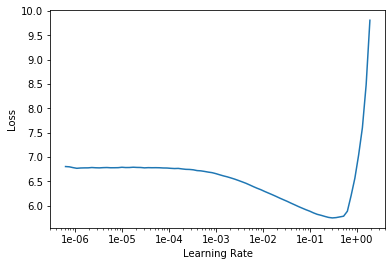

In [29]:
learn.recorder.plot()

In [30]:
learn.freeze()

In [31]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,4.538344,4.332612,0.345899,00:18


In [32]:
learn.unfreeze()

In [33]:
learn.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,4.062820,4.056144,0.379252,00:21
1,3.743655,3.804649,0.410381,00:21
2,3.438715,3.702147,0.425061,00:21
3,3.212454,3.674816,0.429661,00:21
4,3.099466,3.679505,0.430630,00:21


In [34]:
learn.predict('ରେ ଅପ ଗ୍ ରେ ଡ',n_words=10)

'ରେ ଅପ ଗ୍ ରେ ଡ େଲ ସି , ▁ପ୍ରଣୟ ର ▁କ୍ଷତି ▁x x b os'

In [35]:
learn.save_encoder('fine_tuned_enc')

In [36]:
data_clas = TextClasDataBunch.from_df(path=path, train_df=train_df, valid_df=valid_df, tokenizer=tokenizer, vocab=oriya_vocab, text_cols=[0], label_cols=label_cols, bs=16)

In [37]:
data_clas.show_batch()

text,target
"▁x x b os ▁୧୧ ▁ଶହ ▁ସହର ରେ ▁ପହଞ୍ଚି ବ ▁ଜି ଓ ▁ ଗି ଗା ▁ଫାଇ ବର , ▁ ଡେନ ▁ ନେଟ ଓ ୍ <unk> ର୍କ ▁ଓ ▁ହା ଥେ ଓ ୍ <unk> ▁କେ ବୁଲ ର ▁ସର୍ବାଧିକ ▁ଅଂଶ ଧନ ▁ଖ ରି ଦ ▁କଲା ▁ରି ଲା ଏନ୍ ସ",business
"▁x x b os ▁ଏସିଆ ▁କପ୍ ▁: ▁ଭାରତର ▁ସ୍କୋର ▁୨ ୮୫ ▁ ର ନ୍ ▁ଜ ବା ବ୍ ▁ ରେ ▁ହଂକଂ ର ▁ବ୍ୟା ଟି ଂ ▁ଜାରି , ▁ବିନା ▁ଓ ୍ <unk> ିକ େଟ୍ ▁ ରେ ▁ସ୍କୋର ▁ ୮୯ ▁ ର ନ୍",sports
"▁x x b os ▁କ୍ରିକେଟ ର ▁ମୋହ ମ୍ ମ ଦ ▁ସା ମି ଙ୍କ ▁ଜୀବନରେ ▁ଝଡ଼ , ▁ଫେ ସ୍ ▁ବୁ କ୍ ▁ ରେ ▁ହ ୍ <unk> ାଟ ସ୍ ▁ଅପ୍ ▁ ସ୍କ୍ରିନ ୍ ▁ସ ର୍ଟ ▁ସେ ୟାର ▁କଲେ ▁ପତ୍ନୀ ▁ହା ସିନ",sports
"▁x x b os ▁ହ ୍ <unk> ାଟ ସ୍ ▁ଆପ୍ ▁ କୁ ▁ଟକ୍ କର ▁ଦେବାକୁ ▁ଯାଇ ▁ପ ତ ଞ୍ଜ ଳି ▁ଲଞ୍ଚ ▁କଲା ▁ନୂତନ ▁ମେ ସେ ଜି ଂ ▁ଆପ୍ ▁ , ▁କ ’ ଣ ▁ରହିଛି ▁ବିଶେଷତ୍ୱ ▁ଜାଣନ୍ତ ୁ",business
▁x x b os ▁ସର୍ବ ▁ଭାରତୀୟ ▁ଲୁ ତୁର ପ ଙ୍କ ▁କ୍ରିକେଟ ▁କପ୍ ▁: ▁ଜୁ ଭେନ ାଇଲ କୁ ▁୪ ▁ଓ ୍ <unk> ି କେଟ ରେ ▁ହରାଇ ▁ସେ ମି ରେ ▁ମେହ େ ତା ବ୍ ▁କ୍ଲବ,sports


In [38]:
del awd_lstm_config['tie_weights']
del awd_lstm_config['out_bias']

In [39]:
learn = text_classifier_learner(data_clas, arch=AWD_LSTM, drop_mult=0.5, config=awd_lstm_config)

In [40]:
learn.load_encoder('fine_tuned_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (15200 items)
x: TextList
▁x x b os ▁ଅବସର ▁ପାଇଁ ▁ଚିନ୍ତା ▁ନାହିଁ : ▁ମାତ୍ର ▁୩୩ % ▁ଲୋକ ▁କରୁଛନ୍ତି ▁ସଞ୍ଚୟ,▁x x b os ▁‘ ପଦ୍ମ ା ବତ୍ ▁ ’ ▁ରିଲିଜ ୍ ▁ଉପରେ ▁କଟକଣା ▁ଜାରି ▁କଲା ▁ହ ରିଆ ଣା ...,▁x x b os ▁ହା ମି ଲ ଟନ୍ ▁ଟେଷ୍ଟ ରେ ▁ େ ଓ ୍ <unk> ଷ୍ଟ ଇଣ୍ଡ ିଜ୍ ▁୨ ୪୦ ▁ ର ନ୍ ▁ ରେ ▁ପରାସ୍ତ,▁x x b os ▁ଏହି ▁ବଲିଉଡ୍ ▁ଅଭିନେତ୍ରୀ ଙ୍କ ▁ନାଁ ରେ ▁ରଖାଗଲା ▁ଗଣ୍ଡା ର ▁ନାଁ , ଜା ଣ ନ୍ତୁ ...,▁x x b os ▁ ଗି ଲ୍ ▁କ୍ରିଷ୍ଟ , ▁ବା ଉ ଚର ▁ଓ ▁ସାଙ୍ଗାକାରା ଙ୍କ ▁ପରେ ▁ଚତୁର୍ଥ ▁ଧୋ ନି ▁ <unk> ▁୧୦ , ୦୦୦
y: CategoryList
business,entertainment,sports,entertainment,sports
Path: /home/gaurav/PycharmProjects/nlp-for-odia/classification;

Valid: LabelList (3801 items)
x: TextList
▁x x b os ▁ପୂର୍ବ ାଞ୍ଚଳ ▁ ହ୍ୟାଣ୍ଡ ୍ ▁ବଲ୍ ▁: ▁ଓଡ଼ିଶା କୁ ▁କାଂସ୍ୟ,▁x x b os ▁ବସ୍ ▁ , ▁ଟ୍ରେନ ୍ ▁ଗ ନ୍ତ ବ୍ୟ ▁ସ୍ଥଳ ର ▁ଆଗୁଆ ▁ସୂଚନା ▁ଦେବ ▁ଗୁଗୁଲ ୍ ▁ମ୍ୟା ପ୍,▁x x b os ▁ରି ଭର୍ସ ▁ଗ ିୟ ର ରେ ▁ଚାଲି ବ ▁ସ୍ କୁ ଟର , ▁୨ ▁ଘ ଂ ଟା ▁ଚାର୍ଜ ▁କଲେ ▁ବିନା ▁ପେଟ ୍ରୋଲ ୍ ▁ ରେ ▁ ଯିବ ▁୮୦ ▁କିମି ▁ବାଟ,▁x x b os ▁ବେଲ ଜି ୟମ ▁ଓ ▁କାନାଡା ▁ଦଳରେ ▁ପରିବର୍ତନ,▁x x b os ▁ରୋ ନା ଲ୍ ▁ଡୋ

In [41]:
learn.freeze()

In [42]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


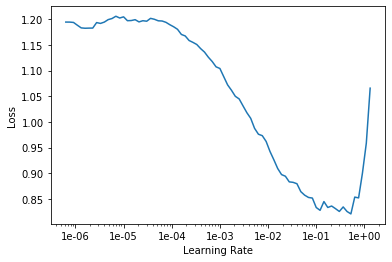

In [43]:
learn.recorder.plot()

In [44]:
learn.loss_func.func

CrossEntropyLoss()

In [45]:
kappa = KappaScore()

In [46]:
learn.metrics = [kappa, accuracy]

In [47]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,kappa_score,accuracy,time
0,0.343443,0.272054,0.843857,0.900026,00:15


In [48]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,kappa_score,accuracy,time
0,0.242218,0.229564,0.895494,0.932912,00:16


In [49]:
learn.save('second-full')

In [50]:
learn.unfreeze()
learn.fit_one_cycle(5, 1e-3, callbacks=[callbacks.SaveModelCallback(learn, every='improvement', monitor='accuracy', name='final')])

epoch,train_loss,valid_loss,kappa_score,accuracy,time
0,0.148600,0.153994,0.910142,0.942384,00:28
1,0.145860,0.150590,0.918813,0.947645,00:28
2,0.066473,0.141598,0.930254,0.955275,00:28
3,0.062254,0.144377,0.927868,0.953696,00:28
4,0.030689,0.137770,0.929230,0.954486,00:28


Better model found at epoch 0 with accuracy value: 0.9423835873603821.
Better model found at epoch 1 with accuracy value: 0.947645366191864.
Better model found at epoch 2 with accuracy value: 0.9552749395370483.


In [51]:
learn.predict('ମୁମ୍ବାଇ : ଗତବର୍ଷ ବିବାହ ବନ୍ଧନରେ ବାନ୍ଧି ହୋଇଥିଲେ ବଲିଉଡ୍‌ର ଦେଶୀଗର୍ଲ ପ୍ରିୟଙ୍କା ଚୋପ୍ରା ଏବଂ ତାଙ୍କ ପ୍ରେମିକ ନିକ୍‌ ଜୋନ୍‌ସ ।')

(Category entertainment,
 tensor(1),
 tensor([2.8126e-04, 9.6329e-01, 3.6427e-02]))

In [52]:
learn.predict("ମୁମ୍ବାଇ : ବଲିଉଡ୍‌ର ଦବଙ୍ଗ ଷ୍ଟାର ସଲମାନ ଖାନ୍‌ କେବଳ ନିଜ ଫିଲ୍ମ ପାଇଁ ନୁହନ୍ତି, ଲୋକମାନଙ୍କୁ ସାହାଯ୍ୟ କରିବାକୁ ନେଇ ମଧ୍ୟ")

(Category entertainment,
 tensor(1),
 tensor([8.2729e-04, 8.4465e-01, 1.5452e-01]))

In [53]:
learn.predict("ଆଗାମୀ ଦିନରେ ବୋଇଂ ୭୩୭ ମ୍ୟାକ୍ସ ୮ ବିମାନ ଅନେକ କମ୍ପାନି ଉଡ଼ାଣ କରୁଥିବାରୁ ସରକାର ଓ ବେସାମରିକ ବିମାନ ଚଳାଚଳ ମହାନିର୍ଦ୍ଦେଶାଳୟ")

(Category business, tensor(0), tensor([9.9733e-01, 2.9930e-16, 2.6665e-03]))

In [54]:
learn.predict("ଦୁଇଦିନ ପାଇଁ ଆୟୋଜନ କରାଯାଇଛି। ହରି ଓମ୍ ଭବନରେ ଅନୁଷ୍ଠିତ ଏହି ଏକ୍ସପୋରେ ଗ୍ରାହକଙ୍କ ପାଇଁ ପୁରୁଣା କାର୍ ବଦଳାଇ ନୂଆ କରା କିଣିବା ")

(Category business, tensor(0), tensor([0.9935, 0.0011, 0.0054]))

In [55]:
learn.predict("ତିରୁବନ୍ତପୁରମ୍‌: କେରଳରେ ଆୟୋଜିତ ଚତୁଃକୋଣୀୟ ୧୯ ବର୍ଷରୁ କମ୍‌ କ୍ରିକେଟ୍‌ ଶୃଙ୍ଖଳାରେ ଅପରାଜେୟ ଭାରତ-ବି ଦଳ ବିଜେତା ଆଖ୍ୟା ହାସଲ ")

(Category sports, tensor(2), tensor([7.7176e-05, 5.7220e-07, 9.9992e-01]))